In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [2]:
def dicky_fuller(df):
    i = 0
    dftest = adfuller(np.diff(df,i), autolag='AIC')
    test_stat = dftest[0]
    critical_val_5 = dftest[4]['5%']
    while test_stat > critical_val_5:
        i+=1
        dftest = adfuller(np.diff(df,i), autolag='AIC')
        test_stat = dftest[0]
        critical_val_5 = dftest[4]['5%']
    return(i)

In [3]:
df_lf = pd.read_csv('../../src/data/df_lf_arima.csv', index_col='time', parse_dates=['time'])
# df_lf.head()

In [4]:
zipcodes = [37115, 37148, 37221, 37174, 37210]

shape of train and test datasets: (61,) (15,) 



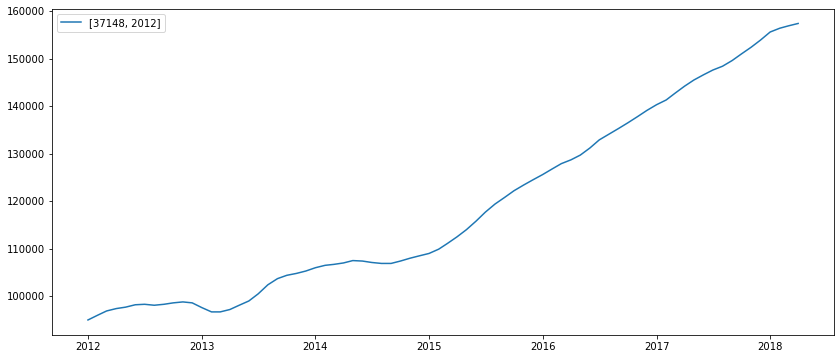

In [5]:
zip_code = zipcodes[1]    # change these params
start_year = 2012   # change these params (1996, 2010 or 2012)
eoti_percent = .8

df_zip_code = df_lf[(df_lf.RegionName== zip_code) & (df_lf.index.year >= start_year)]

eoti = round(df_zip_code.shape[0] * eoti_percent)
df_zip_code_train = df_zip_code.value[:eoti]
df_zip_code_test = df_zip_code.value[eoti:]

print("shape of train and test datasets:", df_zip_code_train.shape, df_zip_code_test.shape, '\n')

plt.subplots(figsize = (14,6))
plt.plot(df_zip_code.value, label=[zip_code,start_year])
plt.legend(loc='best');

# ARIMA

## d

In [6]:
dicky_fuller(df_zip_code_train)

# order of differencing

2

## p, q

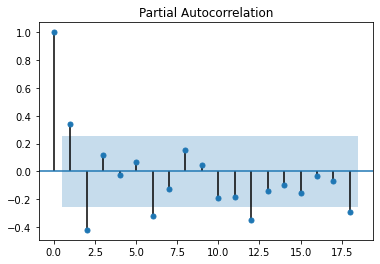

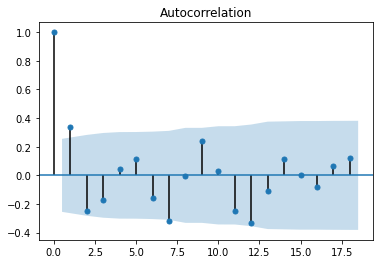

In [20]:
i = dicky_fuller(df_zip_code_train)

plot_pacf(np.diff(df_zip_code_train,i)); #ar

plot_acf(np.diff(df_zip_code_train,i)); #ma

# looks like 0,2,0 are the best params, at i = 2, 
# but they won't work with ARIMA.

In [9]:
# Let's check auto_arima for suggestions, shall we:

auto_arima(df_zip_code_train, start_p=0, d=i, start_q=0, max_p=5, max_q=5, seasonal=False, trace=True)

# NOTE: from the SARIMA model below, 2,2,2 gave better aic. Got better results with ARIMA too.
# But auto_arima didn't even check for it here...

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=854.374, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=855.192, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=855.249, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=852.380, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=856.775, Time=0.10 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.218 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, with_intercept=False)

## Modeling (ARIMA)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   59
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -413.700
Method:                       css-mle   S.D. of innovations            261.906
Date:                Thu, 12 Nov 2020   AIC                            839.399
Time:                        19:23:21   BIC                            851.865
Sample:                    03-01-2012   HQIC                           844.265
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             17.9127      9.136      1.961      0.050       0.006      35.820
ar.L1.D2.value     0.7722      0.203      3.798      0.000       0.374       1.171
ar.L2.D2.value    -0.0893      0.200

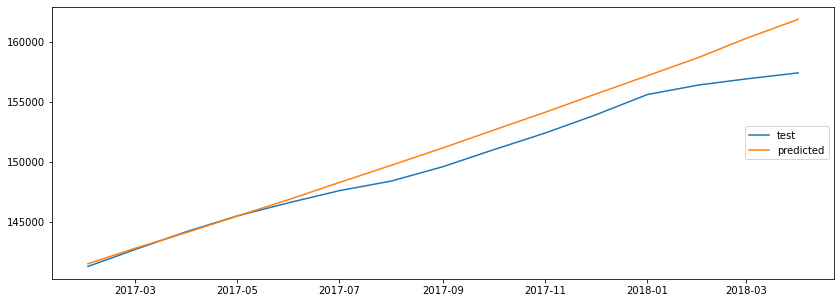

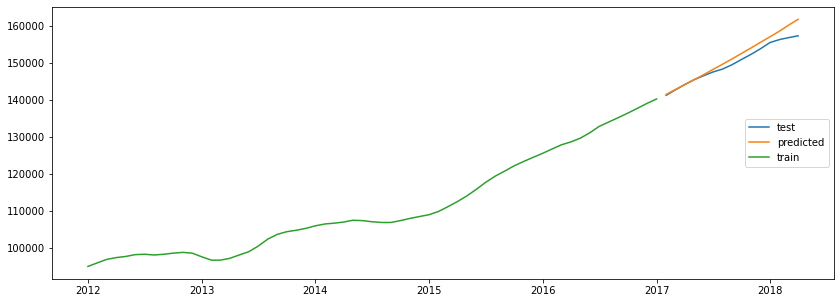

In [13]:
ar, i, ma = [2,2,2] # change these params

model = ARIMA(df_zip_code_train, (ar,i,ma), freq='MS').fit()
y_hat_model = model.predict(typ='levels')
rmse_model = np.sqrt(mean_squared_error(df_zip_code_train[i:], y_hat_model))

test_start_dt = df_zip_code_test.index[0]
test_end_dt = df_zip_code_test.index[-1]
y_hat_model_test = model.predict(start=test_start_dt, end=test_end_dt, typ='levels')
rmse_model_test = np.sqrt(mean_squared_error(df_zip_code_test, y_hat_model_test))

print(model.summary(), '\n')
print('train rmse:', rmse_model, '\n')
print('test rmse:', rmse_model_test, '\n')
print('train aic:', model.aic, '\n')

fig, ax2 = plt.subplots(figsize=(14,5))
ax2.plot(df_zip_code_test, label='test')
ax2.plot(y_hat_model_test, label='predicted')
ax2.legend(loc="right")

fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(df_zip_code_test, label='test')
ax1.plot(y_hat_model_test, label='predicted')
ax1.plot(df_zip_code_train, label='train')
ax1.legend(loc="right");

# SARIMAX

In [10]:
import itertools

i = dicky_fuller(df_zip_code_train)

p = q = range(0, 3)
pdq = list(itertools.product(p, [i], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 2, 0) x (0, 1, 0, 12)
SARIMAX: (0, 2, 0) x (0, 1, 1, 12)
SARIMAX: (0, 2, 0) x (0, 1, 2, 12)
SARIMAX: (0, 2, 0) x (1, 1, 0, 12)
SARIMAX: (0, 2, 0) x (1, 1, 1, 12)
SARIMAX: (0, 2, 0) x (1, 1, 2, 12)
SARIMAX: (0, 2, 0) x (2, 1, 0, 12)
SARIMAX: (0, 2, 0) x (2, 1, 1, 12)
SARIMAX: (0, 2, 0) x (2, 1, 2, 12)
SARIMAX: (0, 2, 1) x (0, 1, 0, 12)
SARIMAX: (0, 2, 1) x (0, 1, 1, 12)
SARIMAX: (0, 2, 1) x (0, 1, 2, 12)
SARIMAX: (0, 2, 1) x (1, 1, 0, 12)
SARIMAX: (0, 2, 1) x (1, 1, 1, 12)
SARIMAX: (0, 2, 1) x (1, 1, 2, 12)
SARIMAX: (0, 2, 1) x (2, 1, 0, 12)
SARIMAX: (0, 2, 1) x (2, 1, 1, 12)
SARIMAX: (0, 2, 1) x (2, 1, 2, 12)
SARIMAX: (0, 2, 2) x (0, 1, 0, 12)
SARIMAX: (0, 2, 2) x (0, 1, 1, 12)
SARIMAX: (0, 2, 2) x (0, 1, 2, 12)
SARIMAX: (0, 2, 2) x (1, 1, 0, 12)
SARIMAX: (0, 2, 2) x (1, 1, 1, 12)
SARIMAX: (0, 2, 2) x (1, 1, 2, 12)
SARIMAX: (0, 2, 2) x (2, 1, 0, 12)
SARIMAX: (0, 2, 2) x (2, 1, 1, 12)
SARIMAX: (0, 2, 2) x (2, 1, 2, 12)
SARIMAX: (1, 2, 0) 

In [11]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(df_zip_code_train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False, 
                         freq='MS')
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:711.8660474764929


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:650.7353784074356
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:315.52675555911594
ARIMA(0, 2, 0)x(1, 1, 0, 12) - AIC:508.737740992948


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ba

ARIMA(0, 2, 0)x(1, 1, 1, 12) - AIC:570.2076760618343
ARIMA(0, 2, 0)x(1, 1, 2, 12) - AIC:316.16672669264017
ARIMA(0, 2, 0)x(2, 1, 0, 12) - AIC:327.08916525036176


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(2, 1, 1, 12) - AIC:518.6359035006183


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 0)x(2, 1, 2, 12) - AIC:318.30564130677493
ARIMA(0, 2, 1)x(0, 1, 0, 12) - AIC:682.3775344051347


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(0, 1, 1, 12) - AIC:1531.1170262255064
ARIMA(0, 2, 1)x(0, 1, 2, 12) - AIC:304.21053501372825
ARIMA(0, 2, 1)x(1, 1, 0, 12) - AIC:507.78688961832364


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(1, 1, 1, 12) - AIC:1540.4112442070248
ARIMA(0, 2, 1)x(1, 1, 2, 12) - AIC:304.4120314512837


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(2, 1, 0, 12) - AIC:328.8768086301847


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 1)x(2, 1, 1, 12) - AIC:715.0164538399478
ARIMA(0, 2, 1)x(2, 1, 2, 12) - AIC:305.965110015243
ARIMA(0, 2, 2)x(0, 1, 0, 12) - AIC:665.779689323845


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(0, 1, 1, 12) - AIC:542.8070467498233
ARIMA(0, 2, 2)x(0, 1, 2, 12) - AIC:286.90183648821915


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 0, 12) - AIC:509.7813954062963


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(1, 1, 1, 12) - AIC:793.4219136873606
ARIMA(0, 2, 2)x(1, 1, 2, 12) - AIC:285.7975665551751


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(2, 1, 0, 12) - AIC:328.5330576794432


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(2, 1, 1, 12) - AIC:2222.218458738798


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 2, 2)x(2, 1, 2, 12) - AIC:288.7558401437701
ARIMA(1, 2, 0)x(0, 1, 0, 12) - AIC:704.5988057230029


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(0, 1, 1, 12) - AIC:1194.0806477764847
ARIMA(1, 2, 0)x(0, 1, 2, 12) - AIC:317.0387870464384
ARIMA(1, 2, 0)x(1, 1, 0, 12) - AIC:491.39577431047076


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(1, 1, 1, 12) - AIC:1107.9486007352339


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(1, 1, 2, 12) - AIC:318.1613769107027
ARIMA(1, 2, 0)x(2, 1, 0, 12) - AIC:315.95012411039033


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 1, 12) - AIC:729.3478432866684


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 0)x(2, 1, 2, 12) - AIC:320.6857819206348
ARIMA(1, 2, 1)x(0, 1, 0, 12) - AIC:684.2541741147786


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(0, 1, 1, 12) - AIC:1130.2049997197255
ARIMA(1, 2, 1)x(0, 1, 2, 12) - AIC:304.2769332492395


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(1, 1, 0, 12) - AIC:492.6016923218222


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(1, 1, 1, 12) - AIC:1245.1514464873587


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(1, 1, 2, 12) - AIC:303.3045197738233


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 0, 12) - AIC:315.6765954213021


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 1, 12) - AIC:433.35755237025796


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 1)x(2, 1, 2, 12) - AIC:315.40768523785476
ARIMA(1, 2, 2)x(0, 1, 0, 12) - AIC:668.6541284337738


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(0, 1, 1, 12) - AIC:721.1452510152508
ARIMA(1, 2, 2)x(0, 1, 2, 12) - AIC:288.89808176402494


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:493.5812053771529


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:852.1829662197024
ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:287.3920681641498


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 0, 12) - AIC:321.4645231363243


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 1, 12) - AIC:596.6564082862785


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 2, 2)x(2, 1, 2, 12) - AIC:299.73250403998856
ARIMA(2, 2, 0)x(0, 1, 0, 12) - AIC:682.2930964997437


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(0, 1, 1, 12) - AIC:1575.6970316088587
ARIMA(2, 2, 0)x(0, 1, 2, 12) - AIC:314.3461164047521
ARIMA(2, 2, 0)x(1, 1, 0, 12) - AIC:477.0697884087539


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(1, 1, 1, 12) - AIC:1553.783202840666


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(1, 1, 2, 12) - AIC:313.3209582538483
ARIMA(2, 2, 0)x(2, 1, 0, 12) - AIC:297.80798560644143


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(2, 1, 1, 12) - AIC:912.818096676849


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 0)x(2, 1, 2, 12) - AIC:298.4133298565625
ARIMA(2, 2, 1)x(0, 1, 0, 12) - AIC:681.8019798308163


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(0, 1, 1, 12) - AIC:1059.1898093767727


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(0, 1, 2, 12) - AIC:301.09866959869527
ARIMA(2, 2, 1)x(1, 1, 0, 12) - AIC:479.0464302396895


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 1, 12) - AIC:495.46007246744


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(1, 1, 2, 12) - AIC:296.8698113195019
ARIMA(2, 2, 1)x(2, 1, 0, 12) - AIC:298.95179003259216


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(2, 1, 1, 12) - AIC:540.7995743837461


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 1)x(2, 1, 2, 12) - AIC:313.41364606391113
ARIMA(2, 2, 2)x(0, 1, 0, 12) - AIC:667.2882514710177


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(0, 1, 1, 12) - AIC:890.0233567335945
ARIMA(2, 2, 2)x(0, 1, 2, 12) - AIC:277.0299903319868


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 0, 12) - AIC:479.0442062048793


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 1, 12) - AIC:852.3445161351706


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(1, 1, 2, 12) - AIC:278.6370486616872
ARIMA(2, 2, 2)x(2, 1, 0, 12) - AIC:298.5641914197237


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 2, 2)x(2, 1, 1, 12) - AIC:478.22199349622935
ARIMA(2, 2, 2)x(2, 1, 2, 12) - AIC:280.5612332610154


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                   61
Model:             SARIMAX(2, 2, 2)x(0, 1, 2, 12)   Log Likelihood                -131.515
Date:                            Thu, 12 Nov 2020   AIC                            277.030
Time:                                    19:23:45   BIC                            284.000
Sample:                                01-01-2012   HQIC                           278.391
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1514      0.051      2.941      0.003       0.050       0.252
ar.L2         -0.8025      0.089   

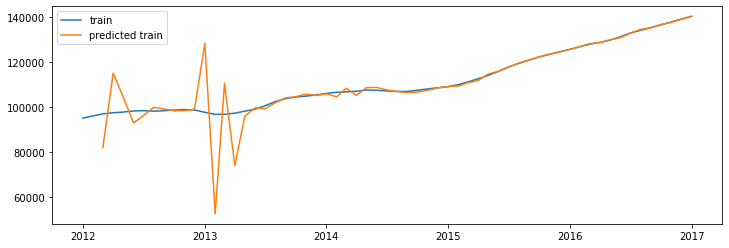

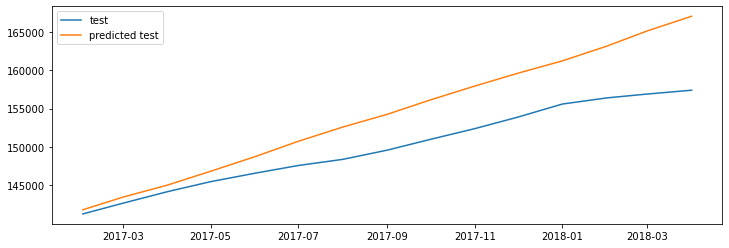

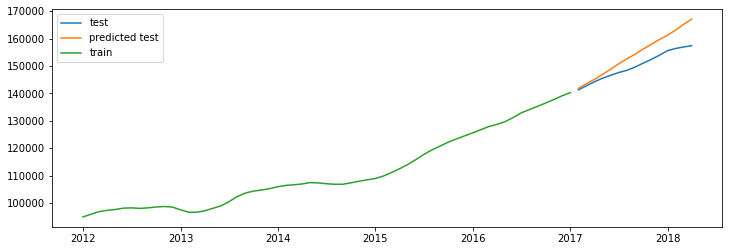

In [14]:
# ARIMA(2, 2, 2)x(0, 1, 2, 12) - AIC:277.0299903319868

p,d,q = [2,2,2]
P,D,Q,s = [0,1,2,12]

sari_mod =SARIMAX(df_zip_code_train,order=(p,d,q),
                  seasonal_order=(P,D,Q,s),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
                  freq='MS').fit()

y_hat_train = sari_mod.predict(typ='levels')
# second order differencing results in the first 2 predictions of a SARIMAX being invalid basically.
# in order to address that, subset from the 3rd prediction/value onwards.
# hence the [d:] below when calculating sarimax rmse train
rmse_sarimax_train = np.sqrt(mean_squared_error(df_zip_code_train[d:], y_hat_train[d:]))

y_hat_test = sari_mod.predict(start=df_zip_code_test.index[0], end=df_zip_code_test.index[-1],typ='levels')
rmse_sarimax_test = np.sqrt(mean_squared_error(df_zip_code_test,y_hat_test))

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(df_zip_code_train, label='train')
ax1.plot(y_hat_train[d:], label='predicted train')
ax1.legend(loc='best');

fig, ax2 = plt.subplots(figsize=(12,4))
ax2.plot(df_zip_code_test, label='test')
ax2.plot(y_hat_test, label='predicted test')
ax2.legend(loc='best')

fig, ax3 = plt.subplots(figsize=(12,4))
ax3.plot(df_zip_code_test, label='test')
ax3.plot(y_hat_test, label='predicted test')
ax3.plot(df_zip_code_train, label='train')
ax3.legend(loc='best')

print(sari_mod.summary(), '\n')

print('(ARIMA) train RMSE:   ', rmse_model,)
print('(SARIMAX) train RMSE: ', rmse_sarimax_train,'\n')

print('(ARIMA) test RMSE:   ', rmse_model_test)
print('(SARIMAX) test RMSE: ', rmse_sarimax_test,'\n')

print('(ARIMA) train AIC:   ', model.aic)
print('(SARIMAX) train AIC: ', sari_mod.aic, '\n')

# Forecast

/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


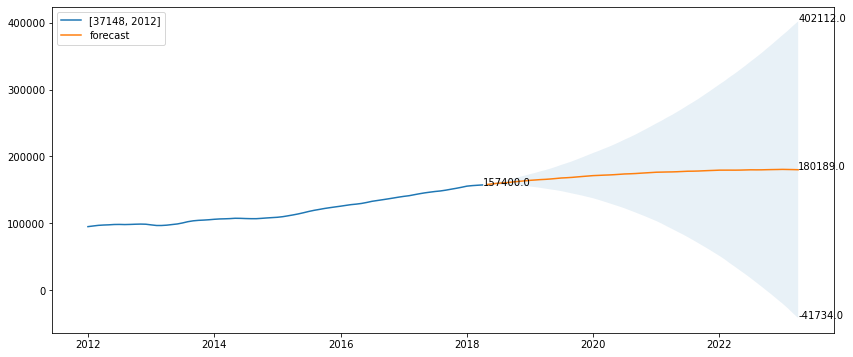

In [16]:
n = 60

sari_mod =SARIMAX(df_zip_code.value, order=(p,d,q),
                  seasonal_order=(P,D,Q,s),
                  enforce_stationarity=False,
                  enforce_invertibility=False,
                  freq='MS').fit()

forecast = sari_mod.forecast(steps = n)

get_forecast = sari_mod.get_forecast(steps=n).summary_frame()

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df_zip_code.value, label=[zip_code,start_year])
ax.plot(forecast, label='forecast')
ax.fill_between(get_forecast.index, get_forecast.mean_ci_lower, get_forecast.mean_ci_upper, alpha=0.1)

ax.annotate(round(df_zip_code.value[-1],0),
            (df_zip_code.index[-1], df_zip_code.value[-1]))
ax.annotate(round(get_forecast.mean_ci_upper[-1],0),
            (get_forecast.index[-1], get_forecast.mean_ci_upper[-1]))
ax.annotate(round(get_forecast['mean'][-1],0),
            (get_forecast.index[-1], get_forecast['mean'][-1]))
ax.annotate(round(get_forecast.mean_ci_lower[-1],0),
            (get_forecast.index[-1], get_forecast.mean_ci_lower[-1]))

ax.legend(loc='upper left');

In [17]:
b = df_zip_code.value[-1]
b

157400.0

In [18]:
e = forecast.values[-1]
e

180189.21115690563

In [19]:
percent_diff_37115 = (e-b)/b
print('difference in percentage: ', percent_diff_37115*100)

difference in percentage:  14.478533136534708


# Conclusion: ARIMA vs Prophet (hunters model)

We're choosing Hunters model bc it has a lower RMSE, & MAPE (calculated below), for our test vs predicted data.

In [138]:
df_zip_code_test

time
2017-02-01    162100.0
2017-03-01    164200.0
2017-04-01    166000.0
2017-05-01    167200.0
2017-06-01    168700.0
2017-07-01    170800.0
2017-08-01    173000.0
2017-09-01    175600.0
2017-10-01    178100.0
2017-11-01    180000.0
2017-12-01    181700.0
2018-01-01    183900.0
2018-02-01    186000.0
2018-03-01    188300.0
2018-04-01    189800.0
Name: value, dtype: float64

In [137]:
y_hat_test

2017-02-01    162093.369182
2017-03-01    164226.805791
2017-04-01    166721.424526
2017-05-01    169416.146019
2017-06-01    171919.269202
2017-07-01    174241.309504
2017-08-01    176771.358794
2017-09-01    179334.631723
2017-10-01    181837.234763
2017-11-01    184284.124348
2017-12-01    186884.032244
2018-01-01    189673.184642
2018-02-01    192499.456913
2018-03-01    195194.912393
2018-04-01    198059.160606
Freq: MS, dtype: float64

In [130]:
MAPE = round(np.mean(np.abs(df_zip_code_test - y_hat_test)/ df_zip_code_test) * 100, 2) #mean absolute percentage error
MAPE

2.13

In [97]:
zip_code

37115